In [54]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statistics as st
%matplotlib inline

In [4]:
dataset_co_cult = np.load('marks_flitered_fluo.npy', allow_pickle = True)

dict_headers = ["norm_MM",
    "cell_marks",
    "nucl_fluo",
    "cell_fluo",
    "marks_fluo",
    "marks_cell_overlap",
    "mark_area",
    "overlap_indices",
    "marks_fluo_overlap",
    "cell_area",
    "marks_cell_overlap_indexes",
    "marks_cellLabels",
    "marks_samplingArea",
    "pmi",
    "overLaps"]

cell_area = dataset_co_cult[9]

# reference, which cells are covered by which marks
cell_marks = dataset_co_cult[1]

# size of every mark
mark_area = dataset_co_cult[6]

# reference of overlap area between cells and marks
marks_cell_overlap = dataset_co_cult[5]



In [5]:
# selected_cells = ['3', '100', '21', '43', '547']
# cell_marks = {k:v for k,v in cell_marks.items() if k in selected_cells}
# cell_area = {k:v for k,v in cell_area.items() if k in selected_cells}
# selected_pixels = ['2']
# for _, cell in cell_marks.items():
#     selected_pixels = selected_pixels + [str(n) for n in cell]
# 
# selected_pixels.sort(key = int)
# mark_area = {k:v for k,v in mark_area.items() if k in selected_pixels}
# 
# selected_pixels

In [14]:
overlap_matrix = pd.DataFrame(index=[int(n) for n in cell_area.keys()], columns=[int(n) for n in mark_area.keys()])
# this is the ablated region specific sampling proportion
sampling_prop_matrix = overlap_matrix.copy()

for cell_i in cell_marks.keys():
    pixels = cell_marks[cell_i]
    for pixel_i, pixel_loc in enumerate(pixels):
        overlap_matrix.loc[int(cell_i), int(pixel_loc)] = marks_cell_overlap[cell_i][pixel_i]
        sampling_prop_matrix.loc[int(cell_i), int(pixel_loc)] = overlap_matrix.loc[int(cell_i), int(pixel_loc)] / mark_area[pixel_loc]

sampling_prop_matrix
    

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
total_cell_pixel_overlap = overlap_matrix.sum(axis=1).replace(to_replace=0, value=1)
# this measure serves as weight of the individual contributions of pixels to a cell.
sampling_spec_matrix = overlap_matrix.divide(total_cell_pixel_overlap, axis=0)
sampling_spec_matrix

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
sampling_prop_threshold = 0.3
sampling_spec_threshold = 0

pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

sampling_prop_matrix_filtered

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ion_intensities = pd.read_csv('sm_annotation_detections.csv')
ion_intensities.columns

ion_intensities = ion_intensities[['C16H30O2', "C25H44NO7P", "C45H78NO8P"]]
#ion_intensities = ion_intensities.iloc[selected_pixels]

ion_intensities

,C16H30O2,C25H44NO7P,C45H78NO8P
0,295.289980,588.615300,263.37576
1,459.018520,602.810550,269.30545
2,123.979935,304.606630,0.00000
3,93.139336,281.583680,0.00000
4,57.312996,264.815520,0.00000
...,...,...,...
2495,126.278410,715.308000,130.08005
2496,88.073560,129.309950,0.00000
2497,341.819640,88.040184,0.00000
2498,487.297640,615.586300,184.42477


In [10]:
norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)

for ion, intensities in ion_intensities.items():
    inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
    # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
    norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
    # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
    weighted_spots = norm_spots * sampling_spec_matrix_filtered
    # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
    # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
    norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)

norm_ion_intensities

,C16H30O2,C25H44NO7P,C45H78NO8P
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
1570,NaN,NaN,NaN
1571,NaN,NaN,NaN
1572,NaN,NaN,NaN
1573,NaN,NaN,NaN


In [11]:
def cell_normalization_Rappez(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)

    for ion, intensities in ion_intensity_matrix.items():
        inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
        # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
        norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
        # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
        weighted_spots = norm_spots * sampling_spec_matrix_filtered
        # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
        # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
        norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)

    
    return(norm_ion_intensities)


# cell_normalization_Rappez(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities)


In [12]:
# this is how martijn performed the calculations

# norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)
# for ion, intensities in ion_intensities.items():
#     sum_prop_matrix = sampling_prop_matrix_filtered.sum(axis=0).replace(to_replace=0, value=pd.NA)
#     
#     norm_spots = intensities / sum_prop_matrix
#     sums = sampling_spec_matrix_filtered.multiply(norm_spots, axis=1)
#     norm_ion_intensities[ion] = sums.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
#     
# norm_ion_intensities

In [13]:
ion_intensities

,C16H30O2,C25H44NO7P,C45H78NO8P
0,295.289980,588.615300,263.37576
1,459.018520,602.810550,269.30545
2,123.979935,304.606630,0.00000
3,93.139336,281.583680,0.00000
4,57.312996,264.815520,0.00000
...,...,...,...
2495,126.278410,715.308000,130.08005
2496,88.073560,129.309950,0.00000
2497,341.819640,88.040184,0.00000
2498,487.297640,615.586300,184.42477


In [57]:
full_pixels_matrix = sampling_prop_matrix.apply(lambda x: x == 1).sum(axis=0)
full_pixels = full_pixels_matrix[full_pixels_matrix == 1].index

full_pixel_intensities = ion_intensities.apply(lambda x: st.median(x[full_pixels]))

        C16H30O2  C25H44NO7P  C45H78NO8P sampling_proportion
0           <NA>        <NA>        <NA>                   0
1     118.517519  158.882611  197.696371            0.013177
2           <NA>        <NA>        <NA>                   0
3           <NA>        <NA>        <NA>                   0
4           <NA>        <NA>        <NA>                   0
...          ...         ...         ...                 ...
2495    0.508518    2.940445    1.489322            0.844884
2496        <NA>        <NA>        <NA>                   0
2497     1.32943    0.349536         0.0            0.874794
2498     2.12634    2.742019    2.288015            0.779715
2499    1.829203    2.349168     1.78711                 1.0

[2500 rows x 4 columns]


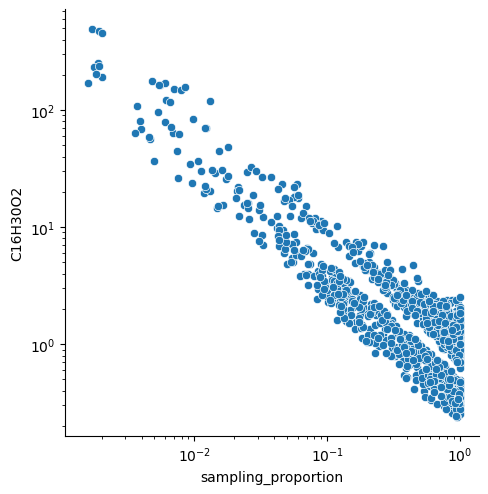

In [111]:
total_pixel_overlap = sampling_prop_matrix.sum(axis=0)
intensity_prop_ratios = ion_intensities.copy().divide(total_pixel_overlap.replace(to_replace=0, value=pd.NA), axis = 0)

norm_intensity_prop_ratios = intensity_prop_ratios.divide(full_pixel_intensities, axis=1)
plot_frame = norm_intensity_prop_ratios.copy()
plot_frame['sampling_proportion'] = total_pixel_overlap
print(plot_frame)
plot = sns.relplot(data=plot_frame.dropna(), x='sampling_proportion', y='C16H30O2')
plot.set(xscale="log")
plot.set(yscale="log")


In [148]:
def quantreg(df, reference = 'sampling_proportion'):
    
    if reference not in df.columns:
        raise ValueError('Reference column not found in DataFrame')

    log_df = np.log10(df.dropna().infer_objects())
    log_df = log_df.replace([np.inf, - np.inf], np.nan).dropna()
    
    slopes = {}
    for ion in log_df.columns:
        if ion == reference: continue
        model = smf.quantreg(ion + ' ~ ' + reference, log_df)
        slopes[ion] = model.fit(q=0.5).params[1]
    
    return(pd.Series(slopes))

quantreg(plot_frame)

      C16H30O2  C25H44NO7P  C45H78NO8P  sampling_proportion
1     2.073783    2.201076    2.295999        -1.880178e+00
13   -0.308310   -0.233365    0.023046        -8.056766e-02
39   -0.451715   -0.515630   -0.152568        -1.084814e-01
63   -0.147794    0.102494   -0.075726         0.000000e+00
72   -0.444782    0.120911   -0.161036         0.000000e+00
...        ...         ...         ...                  ...
2493  0.252952    0.241569    0.749506        -2.129321e-02
2494  0.300920    0.148388    0.768940        -4.821637e-17
2495 -0.293694    0.468413    0.172989        -7.320266e-02
2498  0.327633    0.438071    0.359459        -1.080643e-01
2499  0.262262    0.370914    0.252151        -4.821637e-17

[353 rows x 4 columns]


C16H30O2     -0.977867
C25H44NO7P   -0.804700
C45H78NO8P   -0.871872
dtype: float64